# Linear Mixed-effects Models

Welcome for the first practical session of the day !

### Objectives :
- Get a better idea of medical data, especially longitudinal ones
- Understand mixed-effects models
- Get a taste of state-of-the-art techniques


# The set-up

If you have followed the [installation details](https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions) carefully, you should

- be running this notebook in the `leaspy_tutorial` environment
- having all the needed packages already install

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 1 💬</span> Run the following command lines

In [1]:
!pip install leaspy

In [2]:
!git clone https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions.git

Cloning into 'disease-course-mapping-solutions'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 334 (delta 68), reused 196 (delta 68), pack-reused 138
Receiving objects: 100% (334/334), 38.85 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [3]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.4g}'.format

from leaspy import __watermark__
__watermark__

{'leaspy': '1.2.0',
 'torch': '1.5.1',
 'numpy': '1.19.1',
 'pandas': '1.2.3',
 'scipy': '1.7.3',
 'sklearn': '0.23.1',
 'joblib': '0.14.1',
 'statsmodels': '0.13.1',
 'matplotlib': '3.2.2'}

# Part I: The data

We import a functional medical imaging dataset. We have extracted, for each timepoint, the average value of the metabolic activity of the _putamen_. This brain region is commonly damaged by _Parkinson's disease_.

#### IMPORTANT: The values have been normalized such that a _normal value_ is zero and a _very abrnomal value_ is one.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 2 💬</span> Run the following cell and look at the `head` of the dataframe to better understand what the data are.

In [4]:
from leaspy.datasets import Loader
df = Loader.load_dataset('parkinson-putamen-train_and_test')

df.head()

PUTAMEN
ID     TIME  SPLIT         
GS-001 71.35 train   0.7285
       71.55 train   0.7356
       72.05 train   0.7574
       73.05 train   0.8008
       73.55 train   0.8708

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> The `SPLIT` column already distinguishes the train and test data.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 3 💬</span> Describe the target variable `PUTAMEN` and the explicative variable `TIME`. You can plot:

- Sample size
- Mean, std
- Min & max values
- Quantiles

In [5]:
quantiles = [.05, .25, .5, .75, .95]
df.reset_index().describe(percentiles=quantiles).round(2).T

count  mean   std   min    5%   25%   50%   75%   95%   max
TIME      1997 65.37 10.05 33.14 48.82 58.66 66.48 72.06 81.19 91.24
PUTAMEN   1997  0.71   0.1  0.35  0.55  0.64  0.71  0.77  0.86  0.96

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 4 💬</span> From this value, what can you say about the disease stage of the population?

#### Answer:
The median and mean value is 0.71, so the average disease stage is high for these subjects.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 5 💬</span> Display the data, where the Putamen (y-axis) is plot with respect to the Time (x-axis)

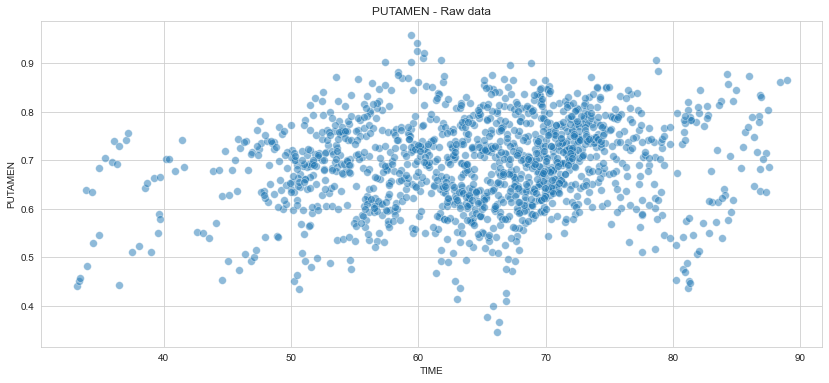

In [6]:
plt.figure(figsize=(14,6))
sns.scatterplot(data=df.xs('train', level='SPLIT').reset_index(),
                x='TIME', y='PUTAMEN', alpha=.5, s=60)
plt.title('PUTAMEN - Raw data')
plt.show()

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> At first look, the _PUTAMEN values_ do not seem highly correlated to _TIME_.


# Part II: Linear Regression

As we are some pro ML players, let's make some predictions : let's try to predict the putamen value based on the time alone.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 6 💬</span> Store the train and test data in `df_train` and `df_test`

In [7]:
pds = pd.IndexSlice
df_train = df.loc[pds[:, :, 'train']].copy()  # one possibility
df_test = df.xs('test', level='SPLIT').copy()  # an other one

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 7 💬</span> Run the linear regression that is in scipy.

Be careful, you have to train it only with the train set!

In [8]:
# help(stats.linregress)

x = df_train.index.get_level_values('TIME')
y = df_train['PUTAMEN']

result = stats.linregress(x, y)
slope, intercept = result.slope, result.intercept

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> To run the notebook smoothly, you must comply to the following rules: we are going to try different models to predict the putamen values based on each observation.

We will store the results in the dataframe `df` such that :

| ID | TIME | SPLIT | PUTAMEN | Model 1 | Model 2 | ... |
| --- | --- | --- | --- | --- | --- | --- |
| GS-001 | 74.4 | train | 0.78 | 0.93 | 0.75 | ... |
| GS-003 | 75.4 | train | 0.44 | 0.84 | 0.46 | ... |
| GS-018 | 51.8 | test | 0.71 | 0.73 | 0.78 | ... |
| GS-056 | 89.2 | train | 0.76 | 0.56 | 0.61 | ... |

This will ease the comparison of the models.

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> No need to add these predictions to `df_train` and `df_test`. You should be able to easily run the notebook by keeping `df_train` the way it is while appending the results in `df`.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 8 💬</span> Add the predictions done by the linear regression in the column `Linear Regression`

In [9]:
df['Linear Regression'] = intercept + slope * df.index.get_level_values('TIME')

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Let's introduce an object and a fonction that will be used to compare the models:
- `overall_results` will be the dataframe that stores the root mean square error on the train and test set for the different models

- `store_rmse_train_test` is the function that given the dataframe `df` and a `model_name` (`Linear Regression` for instance), computes the mean absolute error on the train and test set and stores it in `overall_results`

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 9 💬</span> Run the following cell to see the results

In [10]:
def compute_rmse(df: pd.DataFrame, model_name: str) -> float:
    """Compute RMSE between PUTAMEN column and the <model_name> column of df"""
    y = df['PUTAMEN']
    y_hat = df[model_name]
    err = y_hat - y
    return (err ** 2).mean() ** .5

def store_rmse_train_test(df: pd.DataFrame, overall_results: pd.DataFrame, model_name: str) -> None:
    """Compute RMSE (per data split) and store it in <overall_results> dataframe"""
    for split_name, df_split in df.groupby('SPLIT'):
        overall_results.loc[model_name, split_name] = compute_rmse(df_split, model_name)

overall_results = pd.DataFrame({'train': [], 'test': []})
store_rmse_train_test(df, overall_results, 'Linear Regression')

overall_results

train   test
Linear Regression 0.0914 0.1021

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> The RMSE is higher on the test set as on the train set


Let's look at what we are doing by plotting the data and the linear regression. Throughout the notebook, we will use the function `plot_individuals` that, given a subset of IDs and a model name (as stored in the `df` dataframe) plots the individual data and their prediction

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 10 💬</span> Use the following cell.

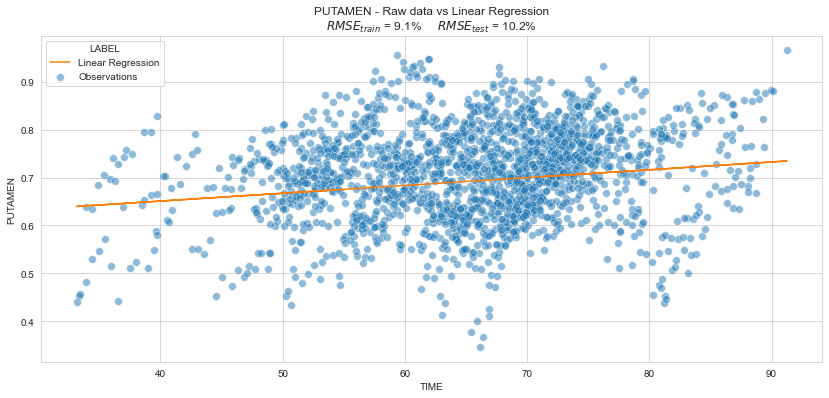

In [11]:
def get_title(overall_results: pd.DataFrame, model_name: str) -> str:
    """Precise model's name and its RMSE train & test"""
    rmse_train = overall_results.loc[model_name, 'train']
    rmse_test = overall_results.loc[model_name, 'test']
    title = f'PUTAMEN - Raw data vs {model_name}\n'
    title += fr'$RMSE_{{train}}$ = {rmse_train:.1%}     $RMSE_{{test}}$ = {rmse_test:.1%}'
    return title

def plot_individuals(df: pd.DataFrame, overall_results: pd.DataFrame, model_name: str, **kwargs):
    # ---- Input manager
    kind = kwargs.get('kind', 'lines')
    sublist = kwargs.get('sublist', None)
    highlight_test = kwargs.get('highlight_test', True)
    ax = kwargs.get('ax', None)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    else:
        plt.figure(figsize=(14, 6))

    # ---- Select subjects
    if sublist is None:
        sublist = df.index.unique('ID')

    # ---- If too many subject, do not display them in the legend
    display_id_legend = len(sublist) <= 10

    # ---- Plot
    if kind == 'scatter':
        # -- Used for Linear Regression
        sns.scatterplot(data=df.reset_index(), x='TIME', y='PUTAMEN', alpha=.5,
                        s=60, label='Observations', ax=ax)
        ax.plot(df.index.get_level_values('TIME').values,
                df[model_name].values,
                label=model_name, c='C1')
        ax.legend(title='LABEL')
        if highlight_test:
            test = df.xs('test', level='SPLIT').loc[sublist].reset_index()
            sns.scatterplot(data=test, x='TIME', y='PUTAMEN', legend=None, ax=ax)

    elif kind == 'lines':
        # -- Used for the other models
        # - Stack observations & reconstructions by the model
        df_stacked = df[['PUTAMEN', model_name]].copy()
        df_stacked.rename(columns={'PUTAMEN': 'Observations'}, inplace=True)
        df_stacked = df_stacked.stack().reset_index().set_index(['ID', 'SPLIT'])
        df_stacked.columns = ['TIME', 'LABEL', 'PUTAMEN']

        # - Plot
        sns.lineplot(data=df_stacked.loc[sublist].reset_index(),
                     x='TIME', y='PUTAMEN', hue='ID', style='LABEL',
                     legend=display_id_legend, ax=ax)
        if highlight_test:
            test = df.xs('test', level='SPLIT').loc[sublist].reset_index()
            sns.scatterplot(data=test, x='TIME', y='PUTAMEN', hue='ID', legend=None, ax=ax)
        if display_id_legend:
            ax.legend(title='LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        raise ValueError('<kind> input accept only "scatter" and "lines".'
                         f' You gave {kind}')

    ax.set_title(get_title(overall_results, model_name))
    return ax

plot_individuals(df, overall_results, 'Linear Regression',
                 kind='scatter', highlight_test=False)
plt.show()

#### Is the previous plot relevant to assess the quality of our model?

We will answer this question in the following cells:

# Part III: The longitudinal aspect


#### <span style='color: #a13203; font-weight: 600;'>💬 Question 11 💬</span> Run the cell to have a better understanding of your data:

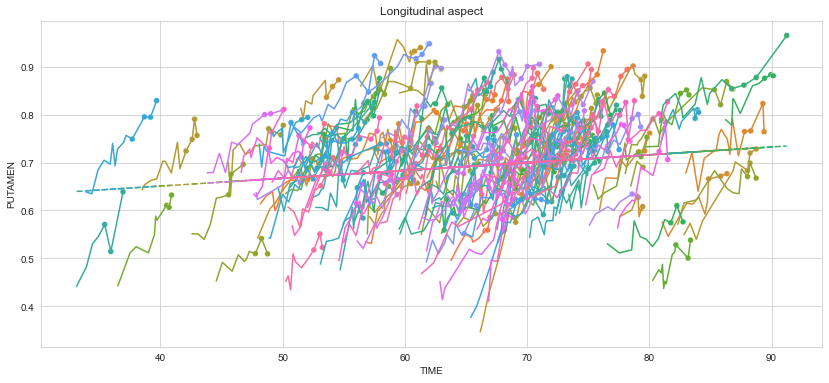

In [12]:
plot_individuals(df, overall_results, 'Linear Regression',
                 kind='lines', highlight_test=True)
plt.title('Longitudinal aspect')
plt.show()

The test data are highlighted with dots.
#### <span style='color: #a13203; font-weight: 600;'>💬 Question 12 💬</span> What are actually the test data ?

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 13 💬</span>Why does the global linear model not describe the temporal evolution of the variable?

# PART IV: Individual Linear Regressions


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> In fact, this is not the best idea to have one general linear regression. Because we do not benefit from individual information. Therefore, let's do one linear regression per individual

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 14 💬</span> Look at what this function is doing and at the result

In [13]:
def compute_individual_parameters(df_patient: pd.DataFrame) -> pd.Series:
    x = df_patient.index.get_level_values('TIME')
    y = df_patient['PUTAMEN']
    # -- Individual Linear regression
    result = stats.linregress(x, y)
    return pd.Series({'INTERCEPT': result.intercept, 'SLOPE_TIME': result.slope})

subject_idx = 'GS-194' # for example

compute_individual_parameters(df_train.loc[[subject_idx]])

INTERCEPT    -0.8079
SLOPE_TIME   0.02519
dtype: float64

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 15 💬</span> Apply the function to everyone

In [14]:
individual_parameters = df_train.groupby('ID').apply(compute_individual_parameters)
individual_parameters.head()

INTERCEPT  SLOPE_TIME
ID                           
GS-001     -2.946     0.05146
GS-002    -0.2529     0.01864
GS-003      0.518    0.003816
GS-004     -1.076     0.02568
GS-005    -0.3688     0.01702

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 16 💬</span> __Now append the result of the model in `df` using the function below.__

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> Take a close look at what we are doing cause we will use the same syntax if other questions.

In [15]:
def compute_individual_reconstruction(df: pd.DataFrame, individual_parameters: pd.DataFrame) -> pd.Series:

    df_with_individual_parameters = df.join(individual_parameters, on='ID')
    df_with_individual_parameters['TIME'] = df.index.get_level_values('TIME')

    # what is the column name for the slope? and what is the corresponding feature
    slope_column = individual_parameters.drop(columns='INTERCEPT').columns.item()
    slope_feature = slope_column.replace('SLOPE_', '')

    slope = df_with_individual_parameters[slope_column]
    intercept = df_with_individual_parameters['INTERCEPT']

    return intercept + slope * df_with_individual_parameters[slope_feature]

df['Individual Linear Regression'] = compute_individual_reconstruction(df, individual_parameters)
df.sample(10, random_state=1111).sort_index()

PUTAMEN  Linear Regression  Individual Linear Regression
ID     TIME  SPLIT                                                          
GS-014 49.57 train   0.6099             0.6665                        0.6338
GS-022 57.8  train   0.7171             0.6799                        0.7478
GS-051 63.37 train    0.648              0.689                        0.6644
GS-053 44.57 train    0.453             0.6584                        0.4648
       48.77 test    0.5096             0.6652                        0.5332
GS-066 66.61 test    0.8426             0.6943                        0.8226
GS-070 71.71 train   0.7602             0.7026                        0.7288
GS-115 71.41 train   0.5497             0.7021                        0.5812
GS-161 73.19 train    0.753              0.705                        0.7567
GS-188 55.03 train   0.7329             0.6754                        0.7123

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 17 💬</span> Use the `store_rmse_train_test` function to get the train and test errors and compare the two models.

In [16]:
store_rmse_train_test(df, overall_results, 'Individual Linear Regression')
overall_results

train   test
Linear Regression             0.0914 0.1021
Individual Linear Regression 0.01783 0.0322

We clearly see that the RMSE is much better!
#### <span style='color: #a13203; font-weight: 600;'>💬 Question 18 💬</span> Create a list with the five patients having the more visits and the five patients having the less visits, then use `plot_individuals` function to display their observations and reconstructions by the model
_Hint_ : use the keyword `sublist`

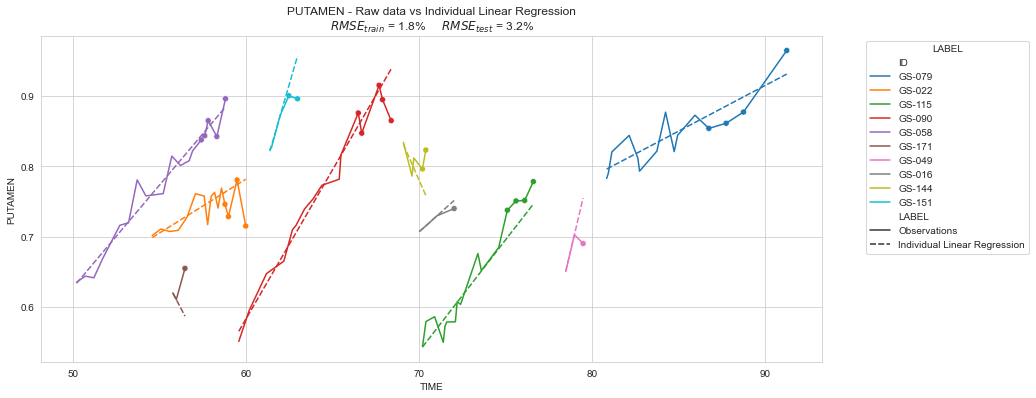

In [17]:
visits_per_subjects = df.groupby('ID').count().sort_values('PUTAMEN')
sublist = visits_per_subjects.tail(5).index.tolist()
sublist += visits_per_subjects.head(5).index.tolist()

plot_individuals(df, overall_results, 'Individual Linear Regression', sublist=sublist)
plt.show()

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 19 💬</span> Explain why $RMSE_{test} >> RMSE_{train}$:

**Answer**: the LM overfit for patients with only few data

# Part V : Linear Mixed effects Model with `statsmodels`
With the previous method, we made a significant improvement. However, we suffer fro an overfitting problem. Let's see what a _mixed effect model_ can do for us!

### Run a LMM with `statsmodels`

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> We will use the `statsmodels` package to run a Linear Mixed Effect Model (LMM or LME in the literature).


#### <span style='color: #a13203; font-weight: 600;'>💬 Question 20 💬</span> Load the following lines to import the packages

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

`Statsmodels` contains several _API_ to create a model. For the ones familiar with _R_, you will be here in a familiar ground with the _formula API_.
- `formula='PUTAMEN ~ TIME + 1'` means that you want to explain _PUTAMEN_ with _TIME_ and an _intercept_
- `groups="ID"` means that you want random effect for all levels of _ID_
- `re_formula="~TIME + 1"` means that you want a random intercept and a random slope for _TIME_

If you go back to the equation you get :
$ PUTAMEN_{id,time} = \underbrace{\alpha*TIME_{id,time} + \beta}_\text{formula} + \underbrace{\alpha_{id}*TIME_{id,time} + \beta_{id}}_\text{re_formula}$

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 21 💬</span> Let's try a very **_naive_** run:

In [19]:
lmm = smf.mixedlm(formula='PUTAMEN ~ 1 + TIME',
                  data=df_train.reset_index(),
                  groups="ID", re_formula="~ 1 + TIME").fit()
lmm.summary()

/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/statsmodels/base

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: PUTAMEN  
No. Observations:   1415    Method:             REML     
No. Groups:         200     Scale:              0.0007   
Min. group size:    2       Log-Likelihood:     2497.0458
Max. group size:    13      Converged:          No       
Mean group size:    7.1                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.685    0.044 -15.644 0.000 -0.771 -0.599
TIME           0.022    0.001  29.528 0.000  0.020  0.023
ID Var         0.003    0.259                            
ID x TIME Cov  0.000    0.005                            
TIME Var       0.000    0.000                            
=========================================================

"""

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> Let's skip the different warning for now and see what happens if we ignore it

Let's try and see.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 22 💬</span> Run the following commands to get the intercept, the slope and the standard-deviation of the residual Gaussian noise

In [20]:
def rename_lmm_params(lmm_params: pd.DataFrame) -> pd.DataFrame:
    """Helper function to cope with different parameters names in LMM results."""
    return lmm_params.add_prefix('SLOPE_').rename({
        'SLOPE_ID': 'INTERCEPT', # for random effect
        'SLOPE_Intercept': 'INTERCEPT', # for fixed effect
    }, axis=1)

def fixed_parameters_of_mixed_model(lmm) -> pd.Series:
    return pd.concat([
        rename_lmm_params(lmm.fe_params),
        pd.Series({'noise_std': lmm.scale ** .5})
    ]).rename('Fixed parameters')

fe = fixed_parameters_of_mixed_model(lmm)
fe.to_frame()

Fixed parameters
INTERCEPT            -0.6849
SLOPE_TIME           0.02168
noise_std            0.02645

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 23 💬</span> Run the following commands to get the variation to the mean slope and intercept
Values on a few subjects and descriptive statistics on all subjects

In [21]:
df_random_effects = rename_lmm_params(pd.DataFrame.from_dict(lmm.random_effects, orient='index'))

example_subjects = [f'GS-{i:03}' for i in range(1, 5+1)]

df_random_effects.loc[example_subjects]

INTERCEPT  SLOPE_TIME
GS-001   -0.01915   -0.001092
GS-002     0.0585    0.004182
GS-003   -0.01197   -0.001002
GS-004   -0.02097   -0.001529
GS-005   0.006285   0.0003635

In [22]:
# Descriptive statistics on all subjects (you can compare empirical results with lmm.cov_re)
df_random_effects.describe(percentiles=[])

INTERCEPT  SLOPE_TIME
count        200         200
mean    2.87e-16    2.13e-17
std       0.0408    0.002931
min     -0.08284   -0.006407
50%    -0.009153  -0.0007057
max       0.1758     0.01214

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 24 💬</span> From the fixed and random effects, compute for each subject its INTERCEPT and SLOPE:

In [23]:
def compute_individual_parameters_from_lmm(lmm):

    df_fixed_effects = rename_lmm_params(lmm.fe_params)
    df_random_effects = rename_lmm_params(pd.DataFrame.from_dict(lmm.random_effects, orient='index'))

    # INTERCEPT and SLOPE_XXX
    df_individual_parameters = df_fixed_effects + df_random_effects

    return df_individual_parameters

df_individual_params = compute_individual_parameters_from_lmm(lmm)
df_individual_params.head()

INTERCEPT  SLOPE_TIME
GS-001     -0.704     0.02059
GS-002    -0.6264     0.02586
GS-003    -0.6968     0.02068
GS-004    -0.7058     0.02015
GS-005    -0.6786     0.02204

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 25 💬</span> Use the `compute_individual_reconstruction` function but with `df_individual_params` to compute the prediction with the new individual effects

In [24]:
df['Linear Mixed Effect Model'] = compute_individual_reconstruction(df, df_individual_params)

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 26 💬</span> __Store the results in `overall_results` (thanks to `store_rmse_train_test` function) and compare the models__

In [25]:
store_rmse_train_test(df, overall_results, 'Linear Mixed Effect Model')
overall_results

train    test
Linear Regression             0.0914  0.1021
Individual Linear Regression 0.01783  0.0322
Linear Mixed Effect Model    0.02453 0.03937

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> The result is worse than with the previous model.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 27 💬</span> __What do you think happened? Let's check it visually__

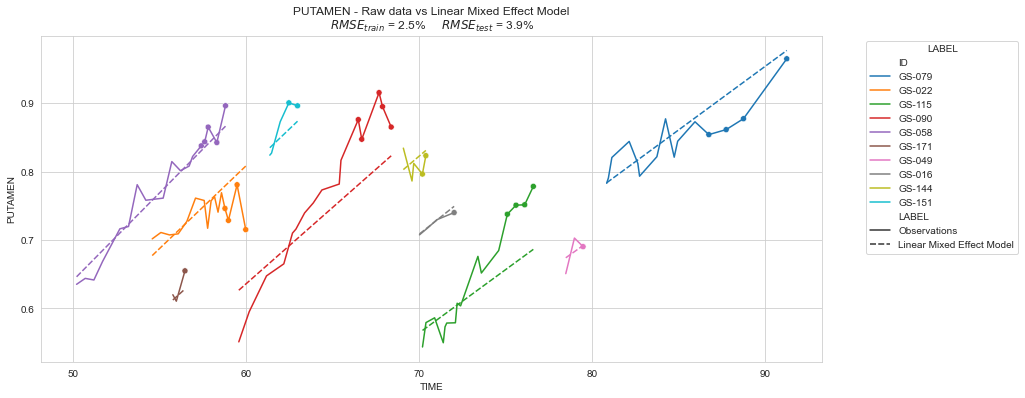

In [26]:
plot_individuals(df, overall_results, 'Linear Mixed Effect Model', sublist=sublist)
plt.show()

<span style='color: #d49800; font-weight: 600;'>⚡ Remark ⚡</span> All the slopes are the same. This is related to the warning above : these are warnings are a way of alerting you that you may be in a non-standard situation. Most likely, one of your variance parameters is converging to zero. Which is the case if you have a look to time variance.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 28 💬</span> Let's rerun it by normalizing the time first. Add to `df_train` and `df_test` a renormalizing function. Be careful to normalize only with the known ages from train.
_Hint_ : Watchout to data leakage!

In [27]:
# ---- We use only train data to compute mean & std
ages = df.index.to_frame()['TIME']
ages_train = ages.xs('train', level='SPLIT')
age_mean = ages_train.mean()
age_std = ages_train.std()

df['TIME_NORMALIZED'] = (ages -  age_mean) / age_std

# ---- Re-create again df_train & df_test to get the new column
df_train = df.xs('train',level='SPLIT')
df_test = df.xs('test',level='SPLIT')

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 29 💬</span> __Rerun the previous mixed lm (some cells above) but with the TIME_NORMALIZED instead of TIME in the formula and re_formula.__

In [28]:
lmm_2 = smf.mixedlm(formula='PUTAMEN ~ TIME_NORMALIZED + 1', data=df_train.reset_index(),
                    groups="ID", re_formula="~TIME_NORMALIZED + 1").fit()

lmm_2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                MixedLM     Dependent Variable:     PUTAMEN  
No. Observations:     1415        Method:                 REML     
No. Groups:           200         Scale:                  0.0005   
Min. group size:      2           Log-Likelihood:         2629.4088
Max. group size:      13          Converged:              Yes      
Mean group size:      7.1                                          
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.679    0.016 43.031 0.000  0.648  0.710
TIME_NORMALIZED           0.232    0.012 20.134 0.000  0.209  0.254
ID Var                    0.045    0.288                           
ID x TIME_NORMALIZED Cov -0.006    0.111                           
TIME_NORMALIZED Var       0.017    0.126                           
===================================================================

"""

Ahaaaaah! No warnings!

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 30 💬</span> Get the parameters as previously in `df_individual_params_2` and store the `INTERCEPT` and `SLOPE_TIME_NORMALIZED`

In [29]:
# –––––––––––––––– #
# –––– Answer –––– #
# –––––––––––––––– #

df_individual_params_2 = compute_individual_parameters_from_lmm(lmm_2)
df_individual_params_2.head()

INTERCEPT  SLOPE_TIME_NORMALIZED
GS-001     0.4564                 0.4176
GS-002     0.9124                 0.1556
GS-003     0.6889                 0.1398
GS-004     0.5852                 0.2495
GS-005     0.7347                 0.1811

Here, we computed

$$ y = SLOPE_{normalized} * TIME_{normalized} + INTERCEPT_{normalized} $$

which corresponds to

$$ y = SLOPE_{normalized} * \frac{(TIME - \mu(ages))}{ \sigma_{ages}} + INTERCEPT_{normalized} $$

which is :

$$ y = SLOPE * TIME + INTERCEPT $$

where $$SLOPE = \frac{SLOPE_{normalized}}{ std_{ages}}$$ and $$INTERCEPT = INTERCEPT_{normalized} - \frac{SLOPE_{normalized} * mean_{ages}}{std_{ages}}$$


#### <span style='color: #a13203; font-weight: 600;'>💬 Question 31 💬</span> Compare the fixed effects from the previous LMM and the new one


In [30]:
fe_2 = fixed_parameters_of_mixed_model(lmm_2).rename({'INTERCEPT': 'INTERCEPT_NORMALIZED'}, axis=1)

fe_2['INTERCEPT'] = fe_2['INTERCEPT_NORMALIZED'] - fe_2['SLOPE_TIME_NORMALIZED'] * age_mean / age_std
fe_2['SLOPE_TIME'] = fe_2['SLOPE_TIME_NORMALIZED'] / age_std

# Noise std-dev is decreased in v2 and mean slope of age is increased
pd.concat([fe.rename('v1'), fe_2.rename('v2')], axis=1).reindex(fe.index)

# Bonus: we can have a look at differences in covariance matrix of random effects

v1      v2
INTERCEPT  -0.6849 -0.8235
SLOPE_TIME 0.02168 0.02325
noise_std  0.02645 0.02169

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 32 💬</span> Use the `compute_individual_reconstruction` function but with `df_individual_params_2` to compute the prediction with the new individual effects

In [31]:
df['Linear Mixed Effect Model - V2'] = compute_individual_reconstruction(df, df_individual_params_2)

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 33 💬</span> __Store the results in `overall_results` (thanks to `store_rmse_train_test` function) and compare the models__

In [32]:
store_rmse_train_test(df, overall_results, 'Linear Mixed Effect Model - V2')
overall_results

train    test
Linear Regression               0.0914  0.1021
Individual Linear Regression   0.01783  0.0322
Linear Mixed Effect Model      0.02453 0.03937
Linear Mixed Effect Model - V2 0.01908 0.02894

The RMSE is much better!
#### <span style='color: #a13203; font-weight: 600;'>💬 Question 34 💬</span> Display the subjects of `sublist` :

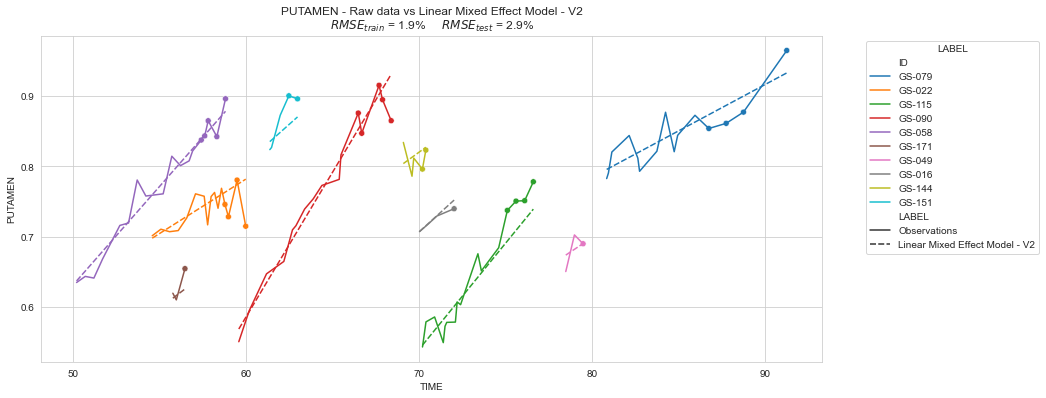

In [33]:
plot_individuals(df, overall_results, 'Linear Mixed Effect Model - V2', sublist=sublist)
plt.show()

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 35 💬</span> What is the main advantage of a Linear Mixed-effects Model compared to multiple Linear Models ?

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 36 💬</span> Let's check the average RMSE per subject depending of the number of timepoints per subjects:

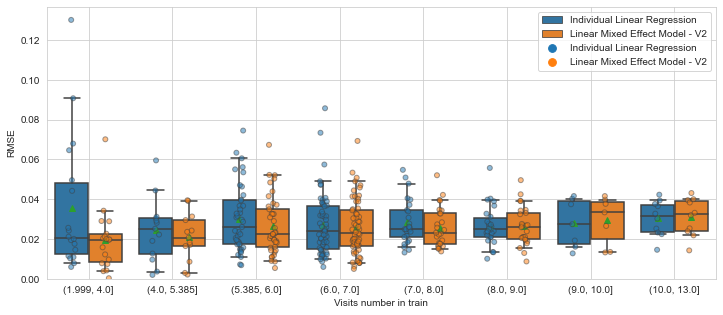

In [34]:
models = ['Individual Linear Regression', 'Linear Mixed Effect Model - V2']

def plot_rmse_by_number_of_visit(models, df=df, *, group_nbr_of_visits: bool = True):
    rmse = df[models].copy()
    rmse.columns.names = ['MODEL']
    rmse = rmse.stack()
    rmse = (rmse - df['PUTAMEN']) ** 2

    nbr_of_visits = rmse.xs('train', level='SPLIT').groupby(['MODEL','ID']).size()
    # we group number of visits together to form ~ balanced groups
    if group_nbr_of_visits:
        nbr_of_visits = pd.qcut(nbr_of_visits, q=13, duplicates='drop')

    rmse = rmse.xs('test',level='SPLIT')
    rmse = rmse.reset_index().rename(columns={0: 'RMSE'})
    rmse = rmse.reset_index()[['ID', 'MODEL', 'RMSE']]
    rmse = rmse.groupby(['MODEL','ID'], sort=False).mean() ** .5
    rmse['Visits number in train'] = nbr_of_visits

    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data=rmse.reset_index(), y='RMSE',
                     x='Visits number in train', hue='MODEL',
                     showmeans=True, whis=[5,95], showfliers=False)
    ax = sns.stripplot(data=rmse.reset_index(), y='RMSE',
                       x='Visits number in train', hue='MODEL',
                       dodge=True, alpha=.5, linewidth=1, ax=ax)

    plt.grid(True, axis='both')
    plt.ylim(0,None)
    plt.legend()
    return ax

plot_rmse_by_number_of_visit(models, df)
plt.show()

# PART VI: A taste of the future - Linear mixed-effect model with _Leaspy_


In the next practical sessions you will learn to use the package developed by the Aramis team. Now, just to be able to compare performances you will run a few methods of leaspy in advance...

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 37 💬</span>  Run the following cell to make the import of leaspy methods, format the data and fit a model :

In [35]:
# --- Import methods
from leaspy import Leaspy, Data, AlgorithmSettings

# --- Format the data
data = Data.from_dataframe(df_train[['PUTAMEN']])

# --- Fit a model
leaspy_univariate = Leaspy('univariate_linear')
settings_fit = AlgorithmSettings('mcmc_saem', seed=0)
leaspy_univariate.fit(data, settings_fit)

 ==> Setting seed to 0
|##################################################|   10000/10000 iterations
Fit with `mcmc_saem` took: 22s
The standard deviation of the noise at the end of the fit is:
2.13%


#### Well it's a bit slow, but here is a joke to wait:
-    What did the triangle say to the circle? “You’re pointless.”

...


Okay, it was short. Here is another one:
-    I had an argument with a 90° angle. It turns out it was right.

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 38 💬</span>  Run the following two cells to make the predictions:

In [36]:
settings_personalize = AlgorithmSettings('scipy_minimize', seed=0)
individual_parameters = leaspy_univariate.personalize(data, settings_personalize)

 ==> Setting seed to 0
|##################################################|   200/200 subjects
Personalize with `scipy_minimize` took: 5s
The standard deviation of the noise at the end of the personalize is:
1.83%


#### <span style='color: #a13203; font-weight: 600;'>💬 Question 39 💬</span>  __Add the predictions to `df`__

In [37]:
timepoints = df.index
df['Leaspy linear'] = leaspy_univariate.estimate(timepoints, individual_parameters)

df.sample(10, random_state=1111).sort_index()

PUTAMEN  Linear Regression  Individual Linear Regression  \
ID     TIME  SPLIT                                                             
GS-014 49.57 train   0.6099             0.6665                        0.6338   
GS-022 57.8  train   0.7171             0.6799                        0.7478   
GS-051 63.37 train    0.648              0.689                        0.6644   
GS-053 44.57 train    0.453             0.6584                        0.4648   
       48.77 test    0.5096             0.6652                        0.5332   
GS-066 66.61 test    0.8426             0.6943                        0.8226   
GS-070 71.71 train   0.7602             0.7026                        0.7288   
GS-115 71.41 train   0.5497             0.7021                        0.5812   
GS-161 73.19 train    0.753              0.705                        0.7567   
GS-188 55.03 train   0.7329             0.6754                        0.7123   

                    Linear Mixed Effect Model  TIME_NORMALIZED  \
ID     TIME  SPLIT                                               
GS-014 49.57 train                     0.6346           -1.512   
GS-022 57.8  train                     0.7547          -0.6865   
GS-051 63.37 train                     0.6729           -0.127   
GS-053 44.57 train                      0.451           -2.015   
       48.77 test                      0.5541           -1.593   
GS-066 66.61 test                      0.8262           0.1981   
GS-070 71.71 train                     0.7338           0.7097   
GS-115 71.41 train                     0.5899           0.6796   
GS-161 73.19 train                     0.7564           0.8583   
GS-188 55.03 train                     0.7089          -0.9648   

                    Linear Mixed Effect Model - V2  Leaspy linear  
ID     TIME  SPLIT                                                 
GS-014 49.57 train                           0.633          0.633  
GS-022 57.8  train                          0.7478         0.7481  
GS-051 63.37 train                          0.6719         0.6712  
GS-053 44.57 train                          0.4649         0.4659  
       48.77 test                           0.5327          0.531  
GS-066 66.61 test                           0.8236         0.8223  
GS-070 71.71 train                          0.7307         0.7302  
GS-115 71.41 train                          0.5824         0.5817  
GS-161 73.19 train                          0.7565         0.7566  
GS-188 55.03 train                          0.7098         0.7113

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 40 💬</span>  __Compute and add the new rmse__

In [38]:
store_rmse_train_test(df, overall_results, 'Leaspy linear')
overall_results

train    test
Linear Regression               0.0914  0.1021
Individual Linear Regression   0.01783  0.0322
Linear Mixed Effect Model      0.02453 0.03937
Linear Mixed Effect Model - V2 0.01908 0.02894
Leaspy linear                  0.01827 0.02789

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 41 💬</span> Display the subjects of `sublist` :

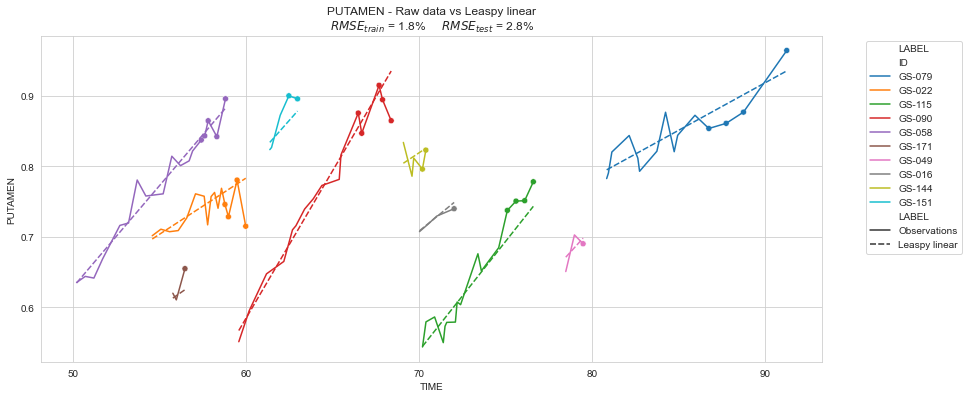

In [39]:
plot_individuals(df, overall_results, 'Leaspy linear', sublist=sublist)
plt.show()

# PART VII: A taste of the future - Non-linear mixed-effect model with _Leaspy_

Again you will use an other model of leaspy...

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 42 💬</span> __Fit the model with the data.__

In [40]:
leaspy_univariate = Leaspy('univariate_logistic')
settings_fit = AlgorithmSettings('mcmc_saem', seed=0)
leaspy_univariate.fit(data, settings_fit)

 ==> Setting seed to 0
|##################################################|   10000/10000 iterations
Fit with `mcmc_saem` took: 25s
The standard deviation of the noise at the end of the fit is:
2.14%


#### Well it's a bit slow, but here is meme to wait:

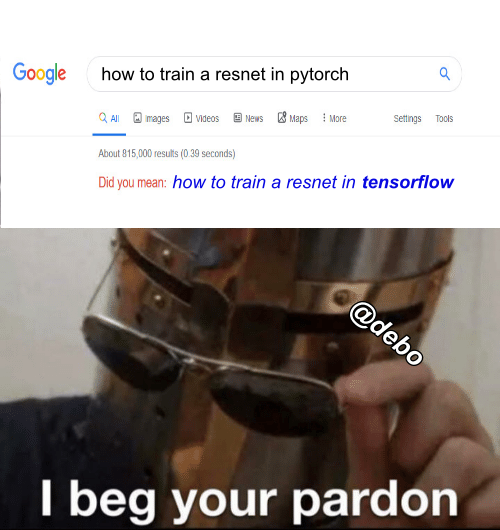

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 43 💬</span>  Run the following two cells to make the predictions:

In [41]:
settings_personalize = AlgorithmSettings('scipy_minimize', seed=0)
individual_parameters = leaspy_univariate.personalize(data, settings_personalize)

 ==> Setting seed to 0
|##################################################|   200/200 subjects
Personalize with `scipy_minimize` took: 4s
The standard deviation of the noise at the end of the personalize is:
1.83%


#### <span style='color: #a13203; font-weight: 600;'>💬 Question 44 💬</span>  __Add the predictions to `df`__

In [42]:
timepoints = df.index
df['Leaspy logistic'] = leaspy_univariate.estimate(timepoints, individual_parameters)

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 45 💬</span>  __Compute and add the new rmse__

In [43]:
store_rmse_train_test(df, overall_results, 'Leaspy logistic')
overall_results

train    test
Linear Regression               0.0914  0.1021
Individual Linear Regression   0.01783  0.0322
Linear Mixed Effect Model      0.02453 0.03937
Linear Mixed Effect Model - V2 0.01908 0.02894
Leaspy linear                  0.01827 0.02789
Leaspy logistic                0.01834 0.02677

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 46 💬</span> Display the subjects of `sublist` :

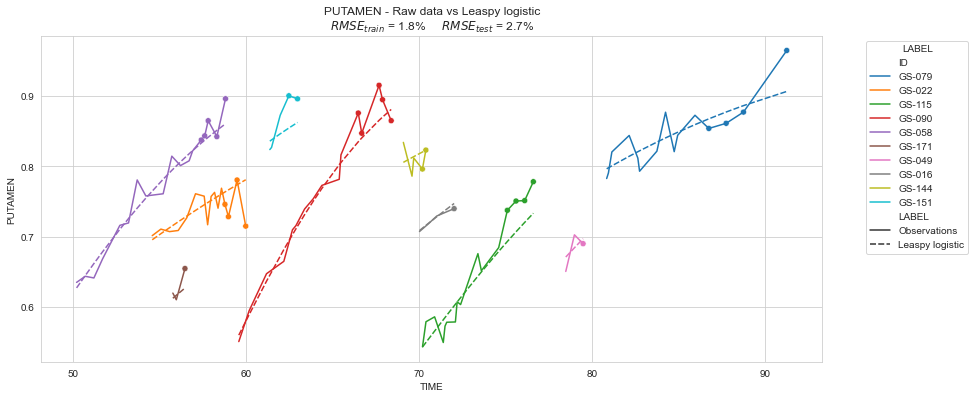

In [44]:
plot_individuals(df, overall_results, 'Leaspy logistic', sublist=sublist)
plt.show()

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 47 💬</span> Check the average RMSE per subject depending of the number of timepoints per subjects

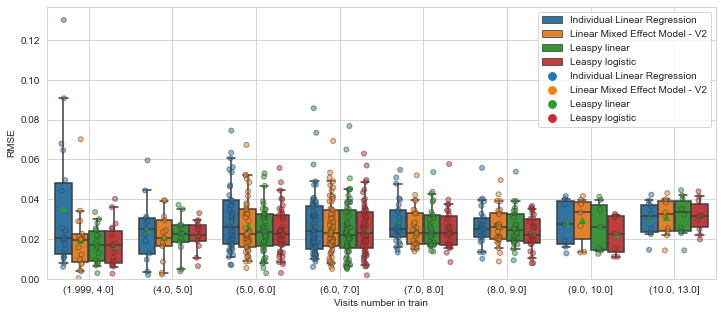

In [45]:
models = ['Individual Linear Regression',
          'Linear Mixed Effect Model - V2',
          'Leaspy linear',
          'Leaspy logistic']

plot_rmse_by_number_of_visit(models, df)
plt.show()

Here we clearly see that the few subjects who have less than 6 timepoints are better reconstructed with a mixed effect model!

# Bonus: have a look at the LMM log-likelihood landscape

In [46]:
import statsmodels.formula.api as smf
from tqdm import tqdm

import site
site.addsitedir('./utils')

from loglikelihood_landscape_lmm import plt_ll_landscape, plt_ll_landscape_

# new model (TIME_norm)
lmm_model = smf.mixedlm(formula="PUTAMEN ~ 1 + TIME_NORMALIZED",
                        data=df.xs('train',level='SPLIT').reset_index(),
                        groups="ID", re_formula="~ 1 + TIME_NORMALIZED")

lmm_model.cov_pen = None

view = dict(
    vmin=2200,
    vmid=2500,
    vmax=2630,
    levels=[2500, 2600, 2620]
)

Rs = {} # placeholder for results

#### <span style='color: #a13203; font-weight: 600;'>💬 Question 48 💬</span> Plot log-likelihood landscapes for LMM model, depending on variance-covariance matrix of random effects

  0%|          | 0/18 [00:00<?, ?it/s]

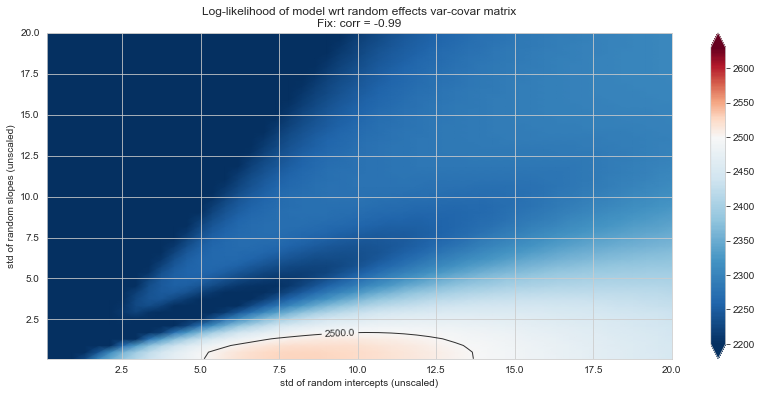

  6%|▌         | 1/18 [01:03<17:58, 63.41s/it]

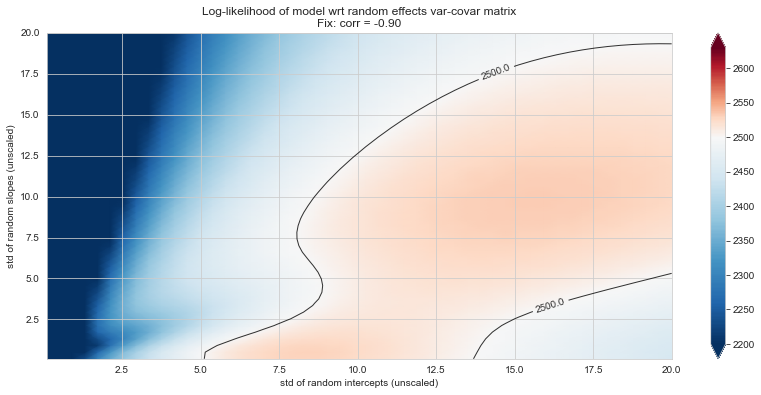

 11%|█         | 2/18 [02:14<17:32, 65.77s/it]

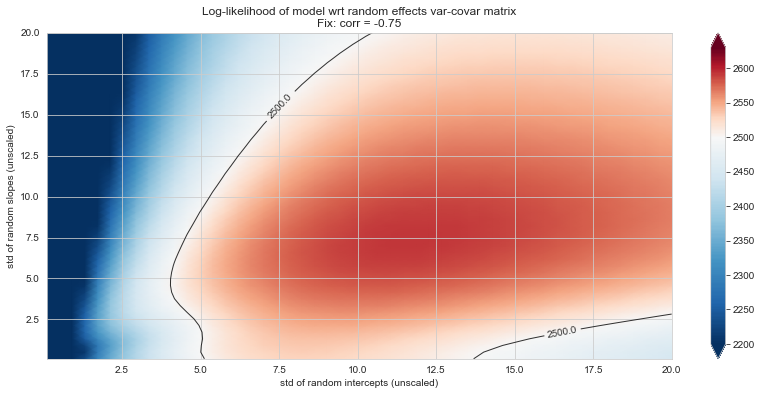

 17%|█▋        | 3/18 [03:41<17:59, 72.00s/it]

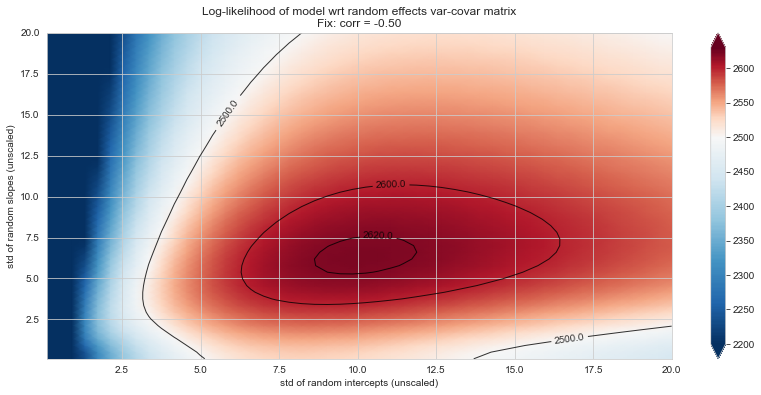

 22%|██▏       | 4/18 [05:02<17:26, 74.75s/it]

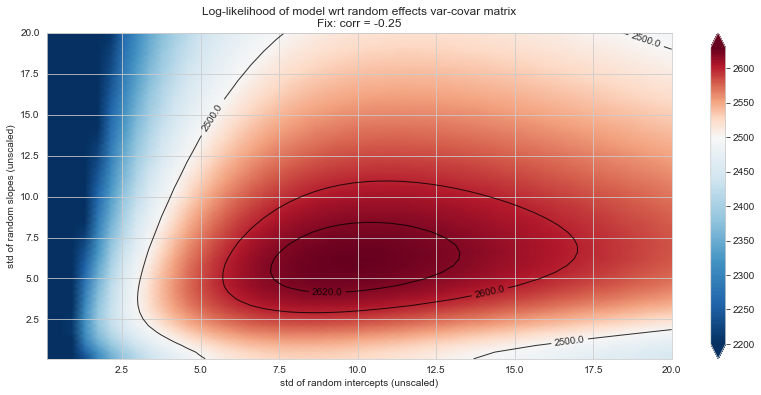

 28%|██▊       | 5/18 [06:27<16:51, 77.80s/it]

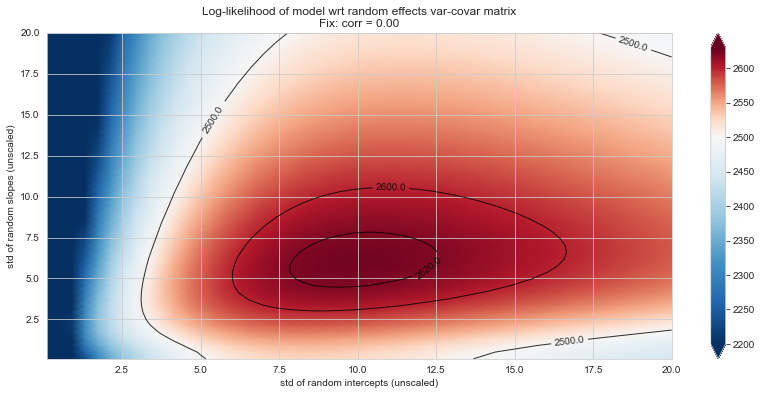

 33%|███▎      | 6/18 [07:55<16:10, 80.89s/it]

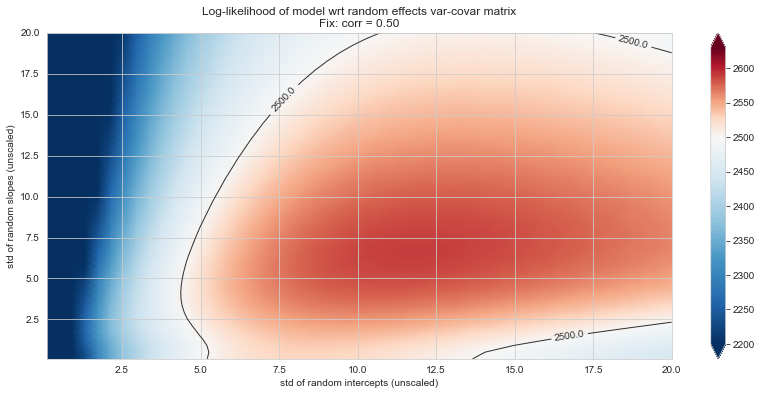

 39%|███▉      | 7/18 [09:26<15:24, 84.06s/it]

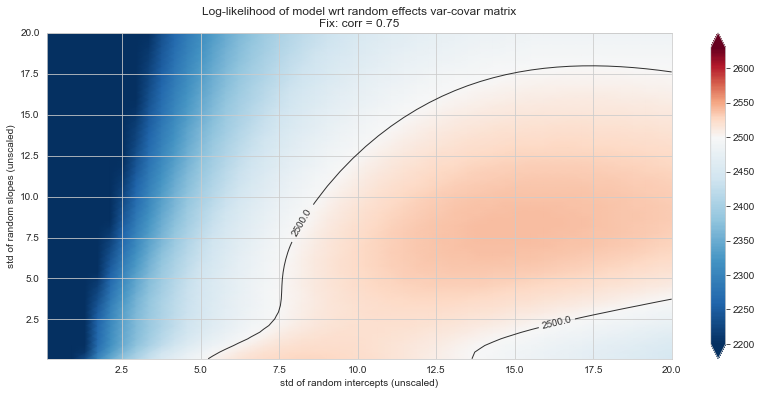

 44%|████▍     | 8/18 [10:51<14:02, 84.30s/it]

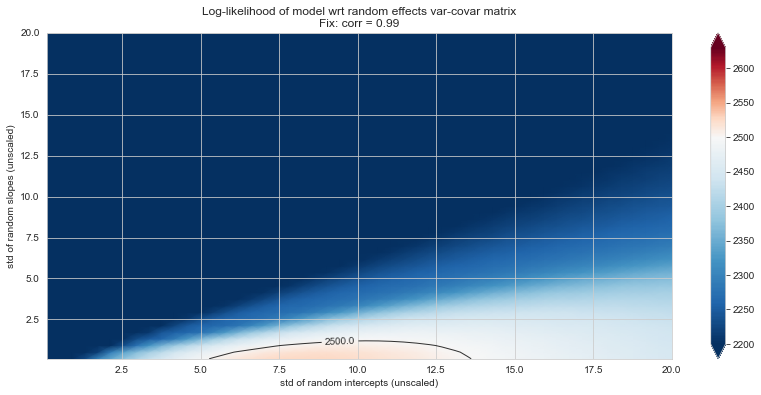

 50%|█████     | 9/18 [12:20<12:50, 85.58s/it]/Users/p-e.poulet/Documents/Aramis/code/ai4health/disease-course-mapping-solutions/solutions/TP1_LMM/utils/loglikelihood_landscape_lmm.py:126: UserWarning: No contour levels were found within the data range.
  contours = plt.contour(X, Y, Z, levels,


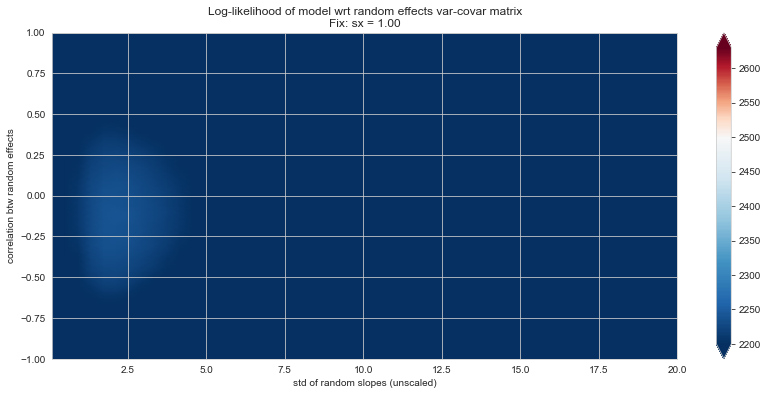

 56%|█████▌    | 10/18 [13:51<11:37, 87.13s/it]

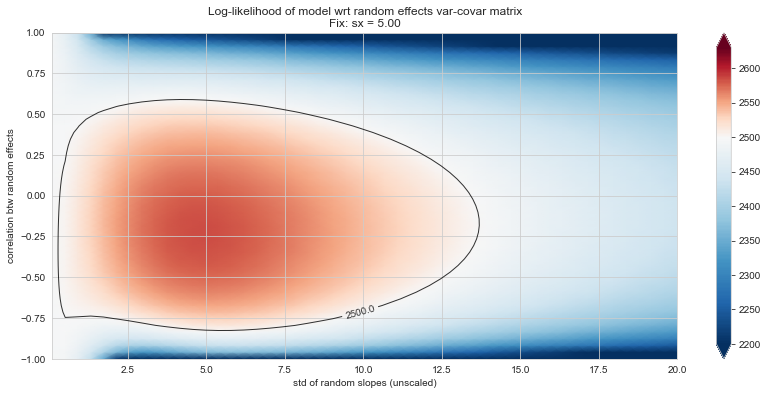

 61%|██████    | 11/18 [15:18<10:10, 87.25s/it]

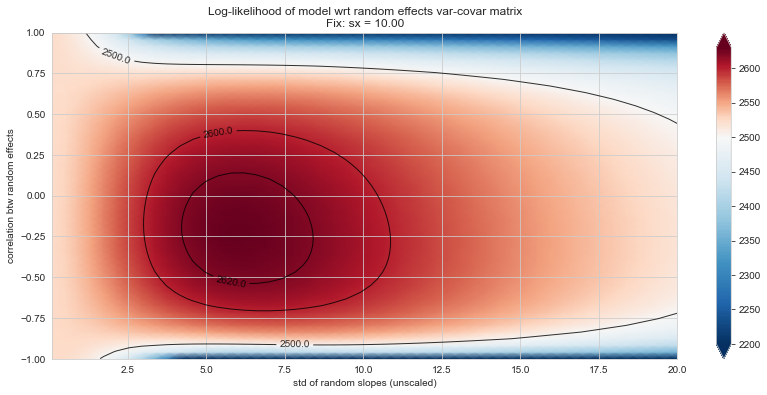

 67%|██████▋   | 12/18 [16:48<08:48, 88.02s/it]

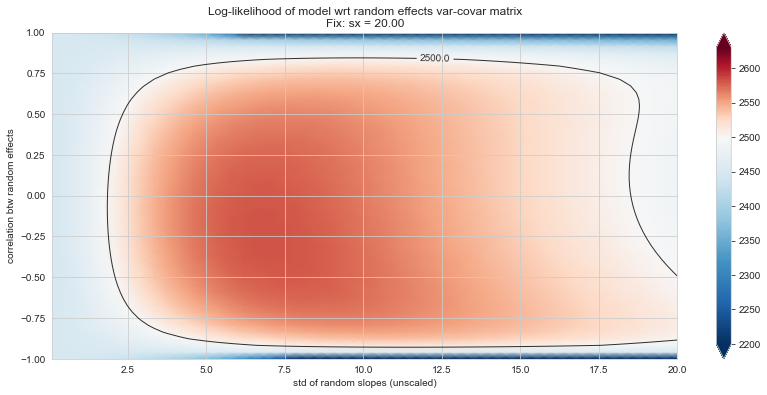

 72%|███████▏  | 13/18 [18:16<07:20, 88.04s/it]

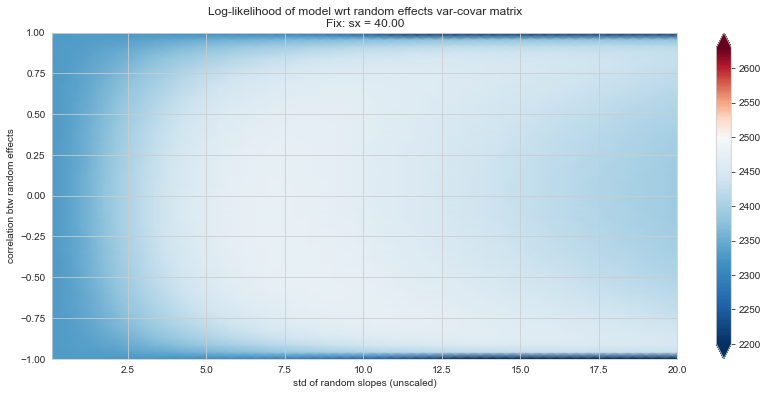

 78%|███████▊  | 14/18 [19:47<05:56, 89.07s/it]

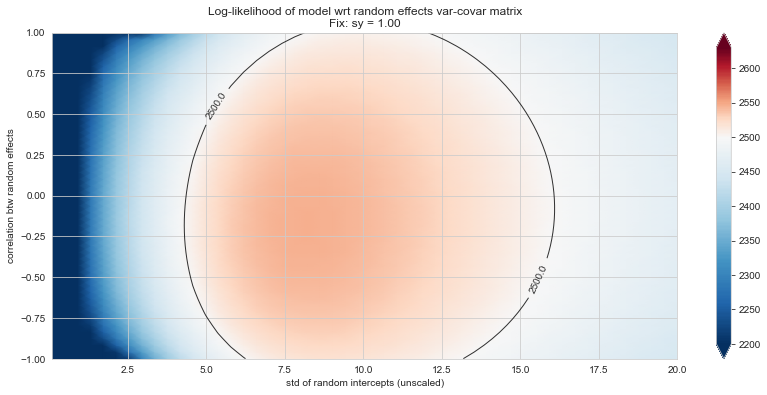

 83%|████████▎ | 15/18 [21:09<04:20, 86.78s/it]

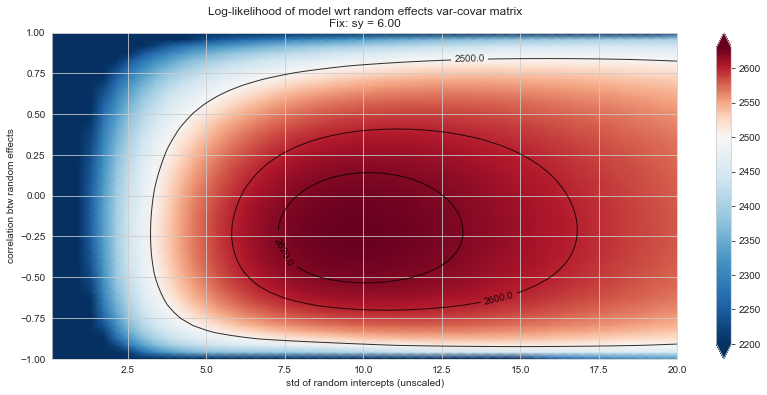

 89%|████████▉ | 16/18 [22:29<02:49, 84.84s/it]

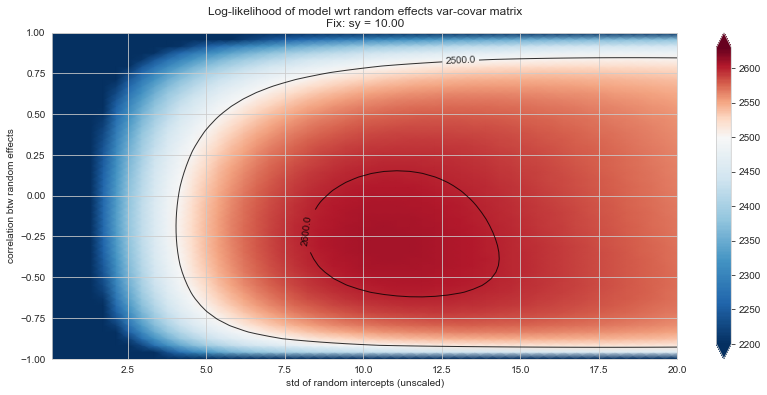

 94%|█████████▍| 17/18 [23:31<01:17, 77.90s/it]

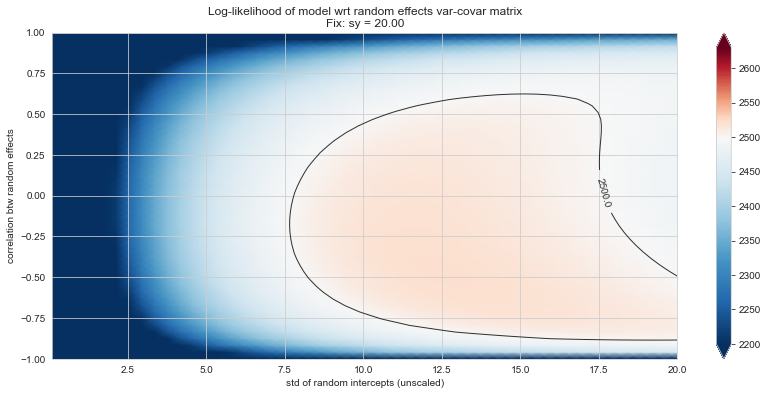

100%|██████████| 18/18 [24:29<00:00, 81.65s/it]


In [47]:
compute = True # uncomment to perform the computations ; disabled by default since computationally expensive

for fix_k, fix_v in tqdm([
    # corr fixed
    ('corr', -.99),
    ('corr', -.9),
    ('corr', -.75),
    ('corr', -.5),
    ('corr', -.25), # ~best
    ('corr', 0),
    ('corr', .5),
    ('corr', .75),
    ('corr', .99),
    # sx fixed
    ('sx', 1.),
    ('sx', 5),
    ('sx', 10), # ~best
    ('sx', 20),
    ('sx', 40),
    # sy fixed
    ('sy', 1),
    ('sy', 6), # ~best
    ('sy', 10),
    ('sy', 20),
]):
    if (fix_k, fix_v) in Rs:
        plt_ll_landscape_(Rs[(fix_k, fix_v)], **view)
    elif compute:
        Rs[(fix_k, fix_v)] = plt_ll_landscape(lmm_model, N=50, **{fix_k: fix_v}, **view)